# Chapter 25

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# install Pint if necessary

try:
    import pint
except ImportError:
    !pip install pint

In [2]:
# download modsim.py if necessary

from os.path import exists

filename = 'modsim.py'
if not exists(filename):
    from urllib.request import urlretrieve
    url = 'https://raw.githubusercontent.com/AllenDowney/ModSim/main/'
    local, _ = urlretrieve(url+filename, filename)
    print('Downloaded ' + local)

In [3]:
# import functions from modsim

from modsim import *

Intro

In the previous chapter we modeled a scenario with constant angular
velocity. In this chapter we make it more complex; we'll model a teapot, on a turntable, revolving with constant angular acceleration and deceleration.

## Angular acceleration

Just as linear acceleration is the derivative of velocity, **angular
acceleration** is the derivative of angular velocity. And just as linear acceleration is caused by force, angular acceleration is caused by the rotational version of force, **torque**. If you are not familiar with torque, you can read about it at <http://modsimpy.com/torque>.

In general, torque is a vector quantity, defined as the **cross
product** of $\vec{r}$ and $\vec{F}$, where $\vec{r}$ is the **lever
arm**, a vector from the point of rotation to the point where the force is applied, and $\vec{F}$ is the vector that represents the magnitude and direction of the force.

However, for the problems in this chapter, we only need the *magnitude* of torque; we don't care about the direction. In that case, we can compute 

$$\tau = r F \sin \theta$$ 

where $\tau$ is torque, $r$ is the length of the lever arm, $F$ is the magnitude of force, and $\theta$ is the angle between $\vec{r}$ and $\vec{F}$.

Since torque is the product of a length and a force, it is expressed in newton meters (Nm).

## Moment of inertia

In the same way that linear acceleration is related to force by Newton's second law of motion, $F=ma$, angular acceleration is related to torque by another form of Newton's law: 

$$\tau = I \alpha$$ 

where $\alpha$ is angular acceleration and $I$ is **moment of inertia**. Just as mass is what makes it hard to accelerate an object, moment of inertia is what makes it hard to spin an object.
(That might sound like a dumb way to describe mass, but might actually be the most fundamental definition.)

In the most general case, a 3-D object rotating around an arbitrary
axis, moment of inertia is a tensor, which is a function that takes a
vector as a parameter and returns a vector as a result.

Fortunately, in a system where all rotation and torque happens around a single axis, we don't have to deal with the most general case. We can treat moment of inertia as a scalar quantity.

For a small object with mass $m$, rotating around a point at distance
$r$, the moment of inertia is $I = m r^2$. For more complex objects, we can compute $I$ by dividing the object into small masses, computing
moments of inertia for each mass, and adding them up.

However, for most simple shapes, people have already done the
calculations; you can just look up the answers. For example, see
<http://modsimpy.com/moment>.

## Teapots and turntables

Tables in Chinese restaurants often have a rotating tray or turntable
that makes it easy for customers to share dishes. These turntables are
supported by low-friction bearings that allow them to turn easily and
glide. However, they can be heavy, especially when they are loaded with food, so they have a high moment of inertia.

Suppose I am sitting at a table with a pot of tea on the turntable
directly in front of me, and the person sitting directly opposite asks
me to pass the tea. I push on the edge of the turntable with 1 N of
force until it has turned 0.5 rad, then let go. The turntable glides
until it comes to a stop 1.5 rad from the starting position. How much
force should I apply for a second push so the teapot glides to a stop
directly opposite me?

We'll answer this question in these steps:

1.  I'll use the results from the first push to estimate the coefficient of friction for the turntable.

2.  As an exercise, you'll use that coefficient of friction to estimate the force needed to rotate the turntable through the remaining angle.

Our simulation will use the following parameters:

1.  The radius of the turntable is 0.5 m, and its weight is 7 kg.

2.  The teapot weights 0.3 kg, and it sits 0.4 m from the center of the turntable.

![Diagram of a turntable with a
teapot.](figs/teapot.pdf){height="2.5in"}

This figure shows the scenario, where $F$ is the force I apply to the turntable at the perimeter, perpendicular to the moment arm, $r$, and $\tau$ is the resulting torque. The blue circle near the bottom is the teapot.

Here's a `Params` object with the parameters of the scenario:

In [4]:
import pint

units = pint.UnitRegistry()
rad = units.radian
m = units.meter
s = units.second
kg = units.kilogram
N = units.newton

In [5]:

from numpy import pi

params = Params(radius_disk=0.5,     # m
                mass_disk=7,         # kg
                radius_pot=0.4,      # m
                mass_pot=0.3,        # kg
                force=1,             # N
                torque_friction=0.2, # N*m
                theta_0=0,           # radian
                theta_push=0.5,      # radian
                theta_test=1.5,      # radian
                theta_target=pi,     # radian
                t_end=20             # s
               )

In [6]:

from numpy import pi

params = Params(radius_disk = 0.5*m,
                mass_disk = 7*kg,
                radius_pot = 0.4*m,
                mass_pot = 0.3*kg,
                force = 1*N,
                torque_friction = 0.2*N*m,
                theta_0 = 0*rad,
                omega_0 = 0*rad/s,
                theta_push = 0.5*rad,
                theta_test = 1.5*rad,
                theta_target = pi*rad,
                t_end = 20*s)

`make_system` creates the initial state, `init`, and computes the total
moment of inertia for the turntable and the teapot.

In [7]:


def make_system(params):
    """Make a system object.
    
    params: Params object
    
    returns: System object
    """
    mass_disk, mass_pot = params.mass_disk, params.mass_pot
    radius_disk, radius_pot = params.radius_disk, params.radius_pot
    
    init = State(theta=params.theta_0, omega=params.omega_0)
    
    I_disk = mass_disk * radius_disk**2 / 2
    I_pot = mass_pot * radius_pot**2
    
    return System(params, 
                  init=init, 
                  I=I_disk+I_pot,
                  )

In the initial state, `theta` represents the angle of the table in rad;
`omega` represents the angular velocity in rad/s.

`I_disk` is the moment of inertia of the turntable, which is based on
the moment of inertia for a horizontal disk revolving around a vertical axis through its center: 

$$I_{disk} = m r^2 / 2$$ 

`I_pot` is the moment
of inertia of the teapot, which I treat as a point mass with:

$$I_{point} = m r^2$$ 

In SI units, moment of inertia is expressed in kg m$^2$.

Now we can make a `System` object:

In [8]:
system1 = make_system(params)

/home/downey/anaconda3/envs/ModSim/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1638: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


Here's a slope that takes the current state, which contains angle and
angular velocity, and returns the derivatives, angular velocity and
angular acceleration:

In [9]:
def slope_func(t, state, system):
    """Computes the derivatives of the state variables.
    
    state: State object
    t: time
    system: System object 
    
    returns: sequence of derivatives
    """
    theta, omega = state
    radius_disk, force = system.radius_disk, system.force
    torque_friction, I = system.torque_friction, system.I
    
    torque = radius_disk * force - torque_friction
    alpha = torque / I
    
    return omega, alpha 

In this scenario, the force I apply to the turntable is always
perpendicular to the lever arm, so $\sin \theta = 1$ and the torque due
to force is $\tau = r F$.

`torque_friction` represents the torque due to friction. Because the
turntable is rotating in the direction of positive `theta`, friction
acts in the direction of negative `theta`.

In [10]:
slope_func(0, system1.init, system1)

(0.0 <Unit('radian / second')>,
 0.32502708559046584 <Unit('newton / kilogram / meter')>)

We are almost ready to run the simulation, but first there's a problem we have to address.

When I stop pushing on the turntable, the angular acceleration changes
abruptly. We could implement the slope function with an `if` statement
that checks the value of `theta` and sets `force` accordingly. And for a coarse model like this one, that might be fine. But we will get more
accurate results if we simulate the system in two phases:

1.  During the first phase, force is constant, and we run until `theta` is 0.5 radians.

2.  During the second phase, force is 0, and we run until `omega` is 0.

Then we can combine the results of the two phases into a single
`TimeFrame`.

Here's the event function I'll use for Phase 1; it stops the simulation when `theta` reaches `theta_end`, which is when I stop pushing:

In [11]:
def event_func1(t, state, system):
    """Stops when theta reaches theta_push.
    
    state: State object
    t: time
    system: System object 
    
    returns: difference from target
    """
    theta, omega = state
    return theta - system.theta_push

As usual, we'll test the event function with the initial conditions.

In [12]:
event_func1(0, system1.init, system1)

-0.5 <Unit('radian')>

Now we can run the first phase of the simulation.

In [13]:


results1, details1 = run_solve_ivp(system1, slope_func,
                                   events=event_func1)
details1.message

'A termination event occurred.'

In [14]:
results1.tail()

,theta,omega
1.683881,0.46080,0.547307
1.701422,0.47045,0.553008
1.718962,0.48020,0.558709
1.736503,0.49005,0.564410
1.754043,0.50000,0.570111




Before we run the second phase, we have to extract the final time and
state of the first phase.

In [15]:
t_0 = results1.index[-1]
init2 = results1.iloc[-1]

Now we can make a `System` object for Phase 2, with the initial state
from Phase 1, and with `force=0`.

In [16]:
system2 = System(system1, t_0=t_0, init=init2, force=0)

For the second phase, we need an event function that stops when the
turntable stops; that is, when angular velocity is 0.

In [17]:
def event_func2(t, state, system):
    """Stops when omega is 0.
    
    state: State object
    t: time
    system: System object 
    
    returns: omega
    """
    theta, omega = state
    return omega

In [18]:
event_func2(system2.t_0, system2.init, system2)

0.570111467688965

Now we can run the second phase.

In [19]:
results2, details2 = run_solve_ivp(system2, slope_func,
                                   events=event_func2)
details2.message

'A termination event occurred.'

Pandas provides `append`, which appends `results2` to the end of
`results1`.

In [20]:
results = results1.append(results2)

Now we can plot `theta` for both phases.

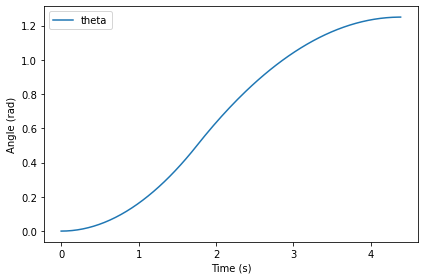

In [21]:


def plot_theta(results):
    results.theta.plot(label='theta')
    decorate(xlabel='Time (s)',
             ylabel='Angle (rad)')
    
plot_theta(results)

And `omega`.

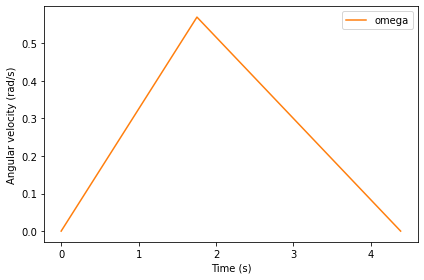

In [22]:
def plot_omega(results):
    results.omega.plot(label='omega', color='C1')
    decorate(xlabel='Time (s)',
             ylabel='Angular velocity (rad/s)')
    
plot_omega(results)

Angular velocity, `omega`, increases linearly while I am pushing, and decreases linearly after I let go. The angle, `theta`, is the integral of angular velocity, so it forms a parabola during each phase.

In the next section, we'll use this simulation to estimate the torque
due to friction.

## Estimating friction

Let's take the code from the previous section and wrap it in a function.

In [23]:
def run_two_phases(force, torque_friction, params):
    """Run both phases.
    
    force: force applied to the turntable
    torque_friction: friction due to torque
    params: Params object
    
    returns: TimeFrame of simulation results
    """
    # put the specified parameters into the Params object
    params = Params(params, 
                    force=force, 
                    torque_friction=torque_friction)

    # run phase 1
    system1 = make_system(params)
    results1, details1 = run_solve_ivp(system1, slope_func, 
                                       events=event_func1)

    # get the final state from phase 1
    t_0 = results1.index[-1]
    init2 = results1.iloc[-1]
    
    # run phase 2
    system2 = System(system1, t_0=t_0, init=init2, force=0)
    results2, details2 = run_solve_ivp(system2, slope_func, 
                                       events=event_func2)
    
    # combine and return the results
    results = results1.append(results2)
    return results

Let's test it with the same parameters.

In [24]:
force = 1
torque_friction = 0.2
results = run_two_phases(params.force, params.torque_friction, params)
results.tail()

/home/downey/anaconda3/envs/ModSim/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1638: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


,theta,omega
4.279865,1.248800,2.280446e-02
4.306175,1.249325,1.710334e-02
4.332486,1.249700,1.140223e-02
4.358797,1.249925,5.701115e-03
4.385107,1.250000,1.110223e-16


And check the results.

In [25]:
theta_final = results.iloc[-1].theta
theta_final

1.2499999999999993

We can use `run_two_phases` to write an error function we can use, with `root_scalar`, to find the torque due to friction that yields the
observed results from the first push, a total rotation of 1.5 rad.

In [26]:
def error_func1(torque_friction, params):
    """Error function for root_scalar.
    
    torque_friction: hypothetical value
    params: Params object
    
    returns: offset from target value
    """
    force = 1
    results = run_two_phases(force, torque_friction, params)
    theta_final = results.iloc[-1].theta
    print(torque_friction, theta_final)
    return theta_final - params.theta_test

Testing the error function.

In [27]:
guess1 = 0.1
error_func1(guess1, params)

0.1 2.4999999999999996


/home/downey/anaconda3/envs/ModSim/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1638: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


0.9999999999999996 <Unit('radian')>

In [28]:
guess2 = 0.2
error_func1(guess2, params)

0.2 1.2499999999999993


-0.25000000000000067 <Unit('radian')>

And running `root_scalar`.

In [29]:
res = root_scalar(error_func1, params, bracket=[guess1, guess2])

0.1 2.4999999999999996
0.1 2.4999999999999996
0.2 1.2499999999999993
0.17999999999999997 1.3888888888888882
0.16559999999999983 1.509661835748793
0.1667519999999999 1.499232393014775
0.16666721279999977 1.4999950848161059
0.16665887943835977 1.5000700883295235


The result is 0.166 Nm, a little less than the initial guess.

## Animation


Here's a draw function we can use to animate the results.

In [30]:
from matplotlib.patches import Circle, Arrow
from matplotlib.pyplot import gca, axis


def draw_func(t, state, params):
    theta, omega = state
    
    # draw a circle for the table
    circle1 = Circle([0, 0], params.radius_disk)
    gca().add_patch(circle1)
    
    # draw a circle for the teapot
    center = pol2cart(theta, params.radius_pot)
    circle2 = Circle(center, 0.05, color='C1')
    gca().add_patch(circle2)

    axis('equal')

In [31]:


params_no_unit = remove_units(params)

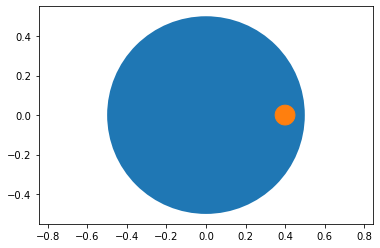

In [32]:
state = results.iloc[0]
draw_func(0, state, params_no_unit)

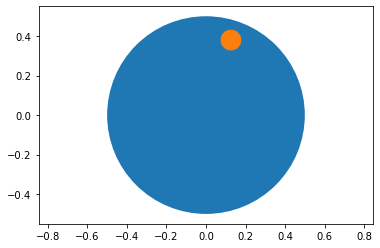

In [33]:


animate(results, draw_func, params_no_unit)

## Summary

Now that we know the torque due to friction, we can compute the force
needed to rotate the turntable through the remaining angle, that is,
from 1.5 rad to 3.14 rad.






### Exercises

Now finish off the example by estimating the force that delivers the teapot to the desired position.

Write an error function that takes `force` and `params` and returns the offset from the desired angle.

In [34]:
# Solution

def error_func2(force, params):
    """Error function for root_scalar.
    
    force: hypothetical value
    params: Params object
    
    returns: offset from target value
    """
    results = run_two_phases(force, params.torque_friction, params)
    theta_final = results.iloc[-1].theta
    print(force, theta_final)
    remaining_angle = params.theta_target - params.theta_test
    return theta_final - remaining_angle

In [35]:
# Solution

guess1 = 1.0
params2 = params.set(torque_friction=torque_friction)
error_func2(guess1, params)

1.0 1.2499999999999993


-0.3915926535897938 <Unit('radian')>

In [36]:
# Solution

guess2 = 2.0
error_func2(guess2, params)

2.0 2.5000000000000036


0.8584073464102104 <Unit('radian')>

In [37]:
# Solution

res = root_scalar(error_func2, params, bracket=[guess1, guess2])

1.0 1.2499999999999993
1.0 1.2499999999999993
2.0 2.5000000000000036
1.3132741228718339 1.6415926535897913
1.3133397865789775 1.6416747332237214


In [38]:
# Solution

force = res.root
results = run_two_phases(force, params.torque_friction, params)
theta_final = results.iloc[-1].theta
theta_final + 1.5

3.1415926535897913